# Mise en œuvre d'un classifieur de texte en _Deep Learning_ avec Keras et ISIDORE

Nous allons utiliser des titres de documents, issus du moteur de recherche SHS [isidore.science](https://isidore.science) pour entrainer un classifier à réseau de neurones à l'aide de Keras. Keras est une API pour le *Deep Learning* qui permet de créer, d'entrainer et d'utiliser des réseaux de neurones (voir les ressources bibliographiques en infra).

Ce document est par ailleurs publié sur [Zenodo](https://doi.org/10.5281/zenodo.3991994). 

Pour entrainer le classifieur, nous constituons un corpus d'entrainement à l'aide de la SPARQL dans le SPARQL endpoint d'isidore.science : 

```SPARQL
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX sioc: <http://rdfs.org/sioc/ns#>
SELECT ?uri ?title where {
?uri sioc:topic <http://aurehal.archives-ouvertes.fr/subject/shs.XXXX>.
?uri dcterms:provenance <https://halshs.archives-ouvertes.fr>.
?uri dcterms:title ?title.
FILTER (lang(?title)='fr')
} LIMIT 2000
```    
Nous collectons 4000 titres :
- 2000 titres en histoire (XXXX = shs.hist), étiqueté 1
- 2000 titres en qui ne sont pas de l'histoire (XXXX = shs.info + shs.socio), étiqueté 0

Nous éliminons les mots vides, signes de ponctuation, etc. pour ne garder que les mots des titre. Exemple : 

```TXT
Vivre  travailler capotteri grecs Venise ;1
Lutter ennemi interne  longue histoire  obsession  brésilienne;1
```

## Préparation des données et entrainement

On charge le corpus d'entrainement :

In [1]:
import pandas as pd

filepath_dict = {'histgeo':'MotsISIDORE-histoire-info-socio.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['words', 'label'], encoding='utf-8', sep=';', na_values='  ', na_filter=True, verbose=True, skip_blank_lines=True)
    df['source'] = source
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

Tokenization took: 13.08 ms
Type conversion took: 18.43 ms
Parser memory cleanup took: 0.02 ms
words     tendances écriture histoire  royaume France 12...
label                                                     1
source                                              histgeo
Name: 0, dtype: object


Préparation des données et création des trains de données. Il s'agit de définir le modèle et la vectorisation du corpus d'entrainement (et on utilise sklearn pour le moment).

In [2]:
from sklearn.model_selection import train_test_split

df_hist = df[df['source'] == 'histgeo'].fillna(' ')

sentencesA = df_hist['words'].values
y = df_hist['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentencesA, y, test_size=0.33, random_state=50)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<13400x22576 sparse matrix of type '<class 'numpy.int64'>'
	with 89709 stored elements in Compressed Sparse Row format>

## Mise en œuvre et utilisation de l'API Keras

On définit le modèle :

In [4]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]

model = Sequential()
model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# 2 classes = binary_crossentropy
# + de 2 classes = categorical_crossentropy

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               2257700   
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 2,262,801
Trainable params: 2,262,801
Non-trainable params: 0
_________________________________________________________________


On lance l'apprentissage du classifieur sur une base de 100 cycles d'apprentissage sur le corpus chargé. Puis on affiche les statistiques courantes :

In [5]:
history = model.fit(X_train, y_train,
                    epochs=6,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Précision de l'entraînement: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Exactitude des tests: {:.4f}".format(accuracy))

Epoch 1/6


2022-02-11 08:56:03.258648: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-11 08:56:03.274063: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2399995000 Hz


1340/1340 [==============================] - 8s 5ms/step - loss: 0.4715 - accuracy: 0.7697 - val_loss: 0.3364 - val_accuracy: 0.8508
Epoch 2/6
1340/1340 [==============================] - 6s 5ms/step - loss: 0.1413 - accuracy: 0.9451 - val_loss: 0.4162 - val_accuracy: 0.8412
Epoch 3/6
1340/1340 [==============================] - 7s 5ms/step - loss: 0.0619 - accuracy: 0.9732 - val_loss: 0.5191 - val_accuracy: 0.8389
Epoch 4/6
1340/1340 [==============================] - 6s 5ms/step - loss: 0.0372 - accuracy: 0.9831 - val_loss: 0.6352 - val_accuracy: 0.8342
Epoch 5/6
1340/1340 [==============================] - 6s 5ms/step - loss: 0.0289 - accuracy: 0.9845 - val_loss: 0.7064 - val_accuracy: 0.8364
Epoch 6/6
1340/1340 [==============================] - 6s 5ms/step - loss: 0.0213 - accuracy: 0.9856 - val_loss: 0.8104 - val_accuracy: 0.8288
Précision de l'entraînement: 0.9872
Exactitude des tests: 0.8288


Analyse et visualisation de l'entrainement :

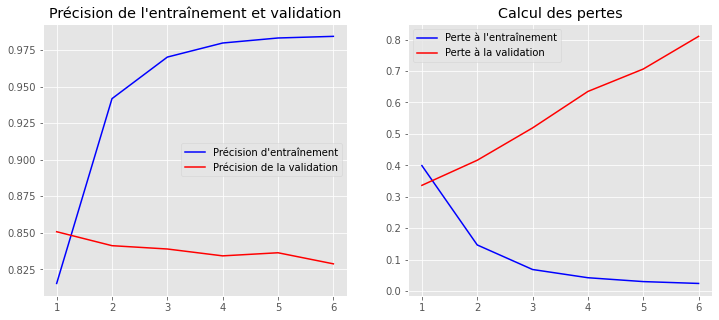

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Précision d\'entraînement')
plt.plot(x, val_acc, 'r', label='Précision de la validation')
plt.title('Précision de l\'entraînement et validation')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Perte à l\'entraînement')
plt.plot(x, val_loss, 'r', label='Perte à la validation')
plt.title('Calcul des pertes')
plt.legend()

## Utilisation du classifieur pour prédire si des titres d'articles sont de l'histoire

On définit des titres d'articles à classifier et on les vectorise pour les classifier avec le classifieur :

In [7]:
sentences_apredire = ['Stratégies éditoriales des musées. Une approche de la médiation par l’accès ouvert aux données numérisées',
                     'Le monde karstique',
                     'Au plus près des âmes et des corps. Une histoire intime des catholiques au xixe siècle', 
                     'Cuba: pour une géographie du socialisme',
                     'Migrations en Turquie',
                     'Les autoroutes et informations',
                     'Les seigneuries et baronies au Moyen-age',
                     'La guerre civile espagnole',
                     'De la Terre à la Lune',
                     'Hommes et structures du Moyen Âge',
                     'Guerriers et Paysans, VIIe – XIIe siècles : premier essor de l‘économie européenne']
X_apredire = vectorizer.transform(sentences_apredire)
X_apredire = X_apredire.todense()
vectorizer.transform(sentences_apredire).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

On utilise l'entrainement avec model.predict_classes de Keras pour prédire les articles qui sont des articles d'histoire. Les articles = 1 sont sans doute des articles en histoire.

In [24]:
predictions = model.predict_classes(X_apredire, verbose=1)
print()
print("Affichage des résultats :")
print()
for i in range(len(X_apredire)):
    if predictions [i] == 0:
        print("\"%s\" = %s ===> pas de l'histoire" % (sentences_apredire [i], predictions [i]))
    else:
        print("\"%s\" = %s ===> sans doute de l'histoire" % (sentences_apredire [i], predictions [i]))

1/1 [==============================] - 0s 54ms/step

Affichage des résultats :

"Stratégies éditoriales des musées. Une approche de la médiation par l’accès ouvert aux données numérisées" = [0] ===> pas de l'histoire
"Le monde karstique" = [0] ===> pas de l'histoire
"Au plus près des âmes et des corps. Une histoire intime des catholiques au xixe siècle" = [1] ===> sans doute de l'histoire
"Cuba: pour une géographie du socialisme" = [1] ===> sans doute de l'histoire
"Migrations en Turquie" = [0] ===> pas de l'histoire
"Les autoroutes et informations" = [0] ===> pas de l'histoire
"Les seigneuries et baronies au Moyen-age" = [1] ===> sans doute de l'histoire
"La guerre civile espagnole" = [1] ===> sans doute de l'histoire
"De la Terre à la Lune" = [0] ===> pas de l'histoire
"Hommes et structures du Moyen Âge" = [1] ===> sans doute de l'histoire
"Guerriers et Paysans, VIIe – XIIe siècles : premier essor de l‘économie européenne" = [1] ===> sans doute de l'histoire


## Ressources
- Géron. A., Deep Learning avec Keras et TensorFlow, DUNOD, 2e ed. (2020).
- Ramsundar, B & al., TensorFlow pour le Deep Learning, O'Reilly (2018).
- Brownlee, J., [How to Prepare Text Data for Deep Learning with Keras](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/) (2017).
- Brownlee, J., [How to Develop a Deep Convolutional Neural Network for Sentiment Analysis (Text Classification)](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/) (2017).